In [1]:
!pip install -q transformers==4.37.2 --quiet
!pip install pydot --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 24.6 MB/s eta 0:00:00


In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from transformers import BertTokenizer, TFBertModel, AutoTokenizer, AutoModel

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/w266_project')
df = pd.read_csv(f"/content/drive/My Drive/Colab Notebooks/w266_project/join_df.csv", header = 0, sep="\t", index_col=0)


Mounted at /content/drive


In [4]:
# Test/train split
X = np.vstack(df['Abstract'])
y = df['JIF']
train_texts, valid_texts, train_labels, test_labels = train_test_split(X, y, test_size=0.3, random_state=42)
valid_labels = np.array(test_labels)
train_labels = np.array(train_labels)

In [5]:
# Load SciBERT tokenizer and model
model_checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [6]:
'''
model_version = 'scibert_scivocab_uncased'
do_lower_case = True
model = BertModel.from_pretrained(model_version)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)
'''

"\nmodel_version = 'scibert_scivocab_uncased'\ndo_lower_case = True\nmodel = BertModel.from_pretrained(model_version)\ntokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)\n"

In [7]:
max_length = 400
train_encodings = bert_tokenizer(list(train_texts[:,0]), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(list(valid_texts[:,0]), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [80]:
def create_bert_regression_model(checkpoint = bert_model,
                                 hidden_size = 50,
                                 dropout=0.3,
                                 learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    ### YOUR CODE HERE
    bert_model.trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    hidden1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(cls_token)
    hidden1 = tf.keras.layers.Dropout(dropout)(hidden1)

    hidden2 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer2')(hidden1)
    hidden2 = tf.keras.layers.Dropout(dropout)(hidden2)

    hidden3 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer3')(hidden2)
    hidden3 = tf.keras.layers.Dropout(dropout)(hidden3)

    regression = tf.keras.layers.Dense(1, activation='linear', name='regression_layer')(hidden3)

    regression_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[regression])

    regression_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.mean_squared_error,
                                 metrics= [tf.keras.metrics.mean_squared_error])
    ### END YOUR CODE
    return regression_model

In [81]:
regression_bert_model = create_bert_regression_model(checkpoint=bert_model, hidden_size = 768, dropout=0.2)

In [82]:
regression_bert_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 400)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 400)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 400)]                0         []                            
 tLayer)                                                                                    

In [83]:
bert_model_history = regression_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                  train_labels,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                  valid_labels),
                                                  batch_size=8,
                                                  epochs=10)

Epoch 1/10
403/403 [==============================] - 180s 409ms/step - loss: 7.8282 - mean_squared_error: 7.8282 - val_loss: 4.7602 - val_mean_squared_error: 4.7602
Epoch 2/10
403/403 [==============================] - 161s 401ms/step - loss: 7.0482 - mean_squared_error: 7.0482 - val_loss: 4.5722 - val_mean_squared_error: 4.5722
Epoch 3/10
403/403 [==============================] - 199s 493ms/step - loss: 6.7578 - mean_squared_error: 6.7578 - val_loss: 4.8810 - val_mean_squared_error: 4.8810
Epoch 4/10
403/403 [==============================] - 198s 493ms/step - loss: 6.6841 - mean_squared_error: 6.6841 - val_loss: 5.0643 - val_mean_squared_error: 5.0643
Epoch 5/10
403/403 [==============================] - 161s 400ms/step - loss: 6.6272 - mean_squared_error: 6.6272 - val_loss: 4.4727 - val_mean_squared_error: 4.4727
Epoch 6/10
403/403 [==============================] - 198s 492ms/step - loss: 6.6863 - mean_squared_error: 6.6863 - val_loss: 4.4025 - val_mean_squared_error: 4.4025
Epoc

In [84]:
regression_bert_model.save("/content/drive/My Drive/Colab Notebooks/w266_project/BERT_regressor")

In [76]:
predictions = regression_bert_model.predict([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask])

44/44 [==============================] - 42s 898ms/step


In [85]:
predictions = predictions.reshape((-1))

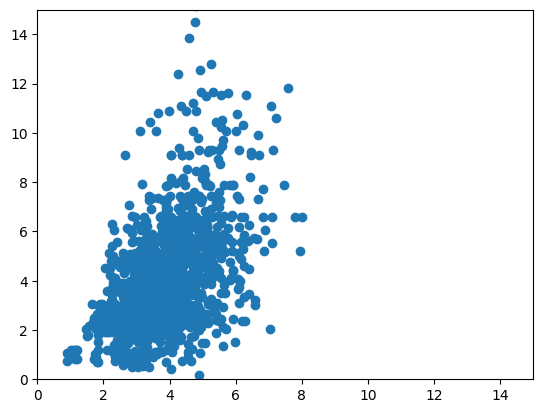

In [86]:
fig, ax = plt.subplots()
ax.scatter(predictions, valid_labels)
ax.set_ylim(0,15)
ax.set_xlim(0,15)
plt.show()

In [88]:
np.corrcoef(predictions, valid_labels)

array([[1.        , 0.46106234],
       [0.46106234, 1.        ]])